In [1]:
import gmsh
import numpy as np
from mpi4py import MPI
from dolfinx import fem, geometry, mesh, plot, default_scalar_type
from dolfinx.io import gmshio, XDMFFile
import ufl
import pyvista
from dolfinx.fem.petsc import LinearProblem
import math

In [2]:
def create_hexagon(x_offset, y_offset, side_length):

    hex_points = []
    hex_lines = []

    # Calculate the vertices of the hexagon
    for i in range(6):
        angle = math.pi / 3 * i
        x = x_offset + side_length * math.cos(angle)
        y = y_offset + side_length * math.sin(angle)
        point_tag = gmsh.model.occ.addPoint(x, y, 0)
        hex_points.append(point_tag)
    
    # Create lines between the vertices
    for i in range(6):
        start_point = hex_points[i]
        end_point = hex_points[(i + 1) % 6]
        line_tag = gmsh.model.occ.addLine(start_point, end_point)
        hex_lines.append(line_tag)
    
    return hex_points, hex_lines

In [3]:
def create_honeycomb(model:gmsh.model, name, num_rows, num_cols, side_length):
    """
    Create a honeycomb lattice structure in Gmsh.

    Parameters:
    num_rows (int): Number of rows in the honeycomb lattice.
    num_cols (int): Number of columns in the honeycomb lattice.
    side_length (float): Length of each side of the hexagons in the lattice.

    Returns:
    list: Tags of the surfaces created for each hexagon.
    """
    model.add(name)
    model.setCurrent(name)


    gap = 2 / 8 * side_length
    dx = side_length * 3 / 2 + gap  # Horizontal distance between the centers of adjacent hexagons
    dy = math.sqrt(3) * 1 * side_length + gap  # Vertical distance between the centers of adjacent hexagons

    all_hex_lines = []
    all_hex_loops = []
    surface_tags = []

    for row in range(num_rows):
        for col in range(num_cols):
            x_offset = col * dx
            y_offset = row * dy
            
            # Offset every other column to create the honeycomb pattern
            if col % 2 == 1:
                y_offset += dy / 2

            hex_points, hex_lines = create_hexagon(x_offset, y_offset, side_length)
            all_hex_lines.extend(hex_lines)
            hex_loop = model.occ.addCurveLoop(hex_lines)
            all_hex_loops.append(hex_loop)
    
    # Create a surface for each hexagonal loop
    for hex_loop in all_hex_loops:
        surface_tag = model.occ.addPlaneSurface([hex_loop])
        surface_tags.append(surface_tag)

    # Synchronize the CAD kernel with the Gmsh model
    model.occ.synchronize()

    # Define the frame dimensions based on the honeycomb layout
    frame_width = (num_cols - 1) * dx
    frame_height = (num_rows - 1) * dy

    # Create a rectangle to act as the frame
    frame_tag = model.occ.addRectangle(0, 0, 0, frame_width, frame_height)

    # Synchronize the CAD kernel again to apply the intersection
    model.occ.synchronize()

    # Perform the intersection between the honeycomb surfaces and the frame
    intersection_result = model.occ.cut([(2,frame_tag)],[(2, surface) for surface in surface_tags], removeObject=False)
    print(intersection_result)
    model.occ.synchronize()
    
    big_frame_tag = model.occ.addRectangle(-gap,-gap,0,frame_width+2*gap,frame_height+2*gap)
    just_frame = model.occ.cut([(2,big_frame_tag)],[(2,frame_tag)], removeObject=True, removeTool=True)
    
    final = model.occ.fuse([(2,frame[1])for frame in just_frame[0]],[(2,res[1]) for res in intersection_result[0]])
    model.occ.synchronize()
    
    extruded_entities=[]
    for dim, tag in final[0]:
        if dim == 2:  # Ensure we're extruding surfaces
            extruded_entities.extend(model.occ.extrude([(dim, tag)], 0, 0, 8))
    
    model.occ.synchronize()

    volume_entities = [model[1] for model in model.getEntities(3)]
    model.addPhysicalGroup(3, volume_entities, tag=420)
    model.setPhysicalName(3, 2, "HCVolume")

    model.mesh.generate(3)
    return model

In [4]:
def create_mesh(comm: MPI.Comm, model: gmsh.model, name: str, filename: str, mode: str):
    """Create a DOLFINx from a Gmsh model and output to file.

    Args:
        comm: MPI communicator top create the mesh on.
        model: Gmsh model.
        name: Name (identifier) of the mesh to add.
        filename: XDMF filename.
        mode: XDMF file mode. "w" (write) or "a" (append).
    """
    msh, ct, ft = gmshio.model_to_mesh(model, comm, rank=0)
    msh.name = name
    ct.name = f"{msh.name}_cells"
    ft.name = f"{msh.name}_facets"
    with XDMFFile(msh.comm, filename, mode) as file:
        msh.topology.create_connectivity(2, 3)
        file.write_mesh(msh)
        file.write_meshtags(
            ct, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry"
        )
        file.write_meshtags(
            ft, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry"
        )
    return msh, ct, ft

In [5]:
gmsh.initialize()
model = gmsh.model()
model = create_honeycomb(model, "HC", 5,5,1)
print(model)
gmsh.fltk.run()
msh, ct, ft=create_mesh(MPI.COMM_SELF,model,"theModel",f"out_gmsh/mesh_rank_{MPI.COMM_WORLD.rank}.xdmf", "w")

([(2, 27)], [[(2, 27)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []])         
Info    : Cannot bind existing OpenCASCADE surface 28 to second tag 27                                                                
Info    : Could not preserve tag of 2D object 27 (->28)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 155 (Line)
Info    : [ 10%] Meshing curve 156 (Line)
Info    : [ 10%] Meshing curve 158 (Line)
Info    : [ 10%] Meshing curve 159 (Line)
Info    : [ 10%] Meshing curve 160 (Line)
Info    : [ 10%] Meshing curve 161 (Line)
Info    : [ 10%] Meshing curve 163 (Line)
Info    : [ 10%] Meshing curve 164 (Line)
Info    : [ 10%] Meshing curve 165 (Line)
Info    : [ 10%] Meshing curve 166 (Line)
Info    : [ 10%] Meshing curve 168 (Line)
Info    : [ 10%] Meshing curve 169 (Line)
Info    : [ 10%] Meshing curve 170 (Line)
Info    : [ 10%] Meshing curve 171 (Line)
Info    : [ 10%] Meshing curve 173 (Line)
Info    : [ 10%] Mesh

In [6]:
L = 1
W = 0.2
mu = 1
rho = 0
delta = W / L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [7]:
V = fem.functionspace(msh, ("Lagrange",1,(msh.geometry.dim, )))

num_rows = 5
side_length = 1
gap = 2 / 8 * side_length
dy = math.sqrt(3) * 1 * side_length + gap
frame_height = (num_rows - 1) * dy

def bottom_boundary(x):
    return np.isclose(x[1], 0)

boundary_dofs_bottom = fem.locate_dofs_geometrical(V, bottom_boundary)

u_bottom = fem.Function(V)
with u_bottom.vector.localForm() as loc:
    loc.set(0.0)

bc = fem.dirichletbc(u_bottom, boundary_dofs_bottom)
T = fem.Constant(msh, default_scalar_type((0, -0.005, 0)))
ds = ufl.Measure("ds", domain=msh)

def epsilon(u):
    return 1/2*(ufl.nabla_grad(u)+ufl.nabla_grad(u).T)  # Equivalent to 0.5*(ufl.nabla_grad(u) + ufl.nabla_grad(u).T)


def sigma(u):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(3) + 2 * mu * epsilon(u)


u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(msh, default_scalar_type((0, 0, -rho * g)))
a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

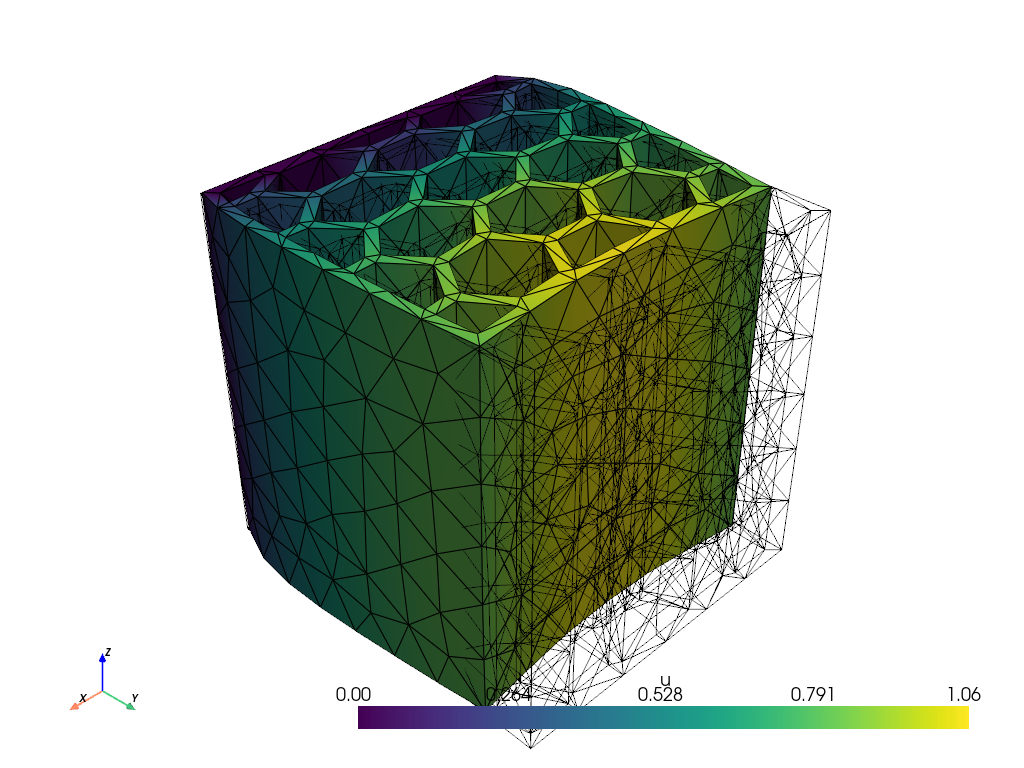

In [8]:
pyvista.start_xvfb()

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Attach vector values to grid and warp grid by vector
grid["u"] = uh.x.array.reshape((geometry.shape[0], 3))
actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("u", factor=1.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
if not pyvista.OFF_SCREEN:
    p.show()
else:
    figure_as_array = p.screenshot("deflection.png")